In [1]:
from pyspark.sql import SparkSession
import pandas as pd

In [2]:
import os

os.environ["JAVA_HOME"] = 'C:\Program Files\Java\jre1.8.0_351'

In [3]:
spark = SparkSession.builder.appName(
    'Create_Plots').master("local").getOrCreate()
 
authors = spark.read.csv('Telecom Churn Dataset.csv', sep=',',
                         inferSchema=True, header=True)
 
df = authors.toPandas()
df.head()

,ID,Gender,SeniorCitizen,Married,Tenure,PhoneService,MultipleLines,InternetService,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Female,0,Yes,1,No,No,DSL,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,Male,0,No,34,Yes,No,DSL,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,2,Male,0,No,2,Yes,No,DSL,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,3,Male,0,No,45,No,No,DSL,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,4,Female,0,No,2,Yes,No,Fiber optic,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


array([[<AxesSubplot: title={'center': 'ID'}>,
        <AxesSubplot: title={'center': 'SeniorCitizen'}>],
       [<AxesSubplot: title={'center': 'Tenure'}>,
        <AxesSubplot: title={'center': 'MonthlyCharges'}>],
       [<AxesSubplot: title={'center': 'TotalCharges'}>, <AxesSubplot: >]],
      dtype=object)

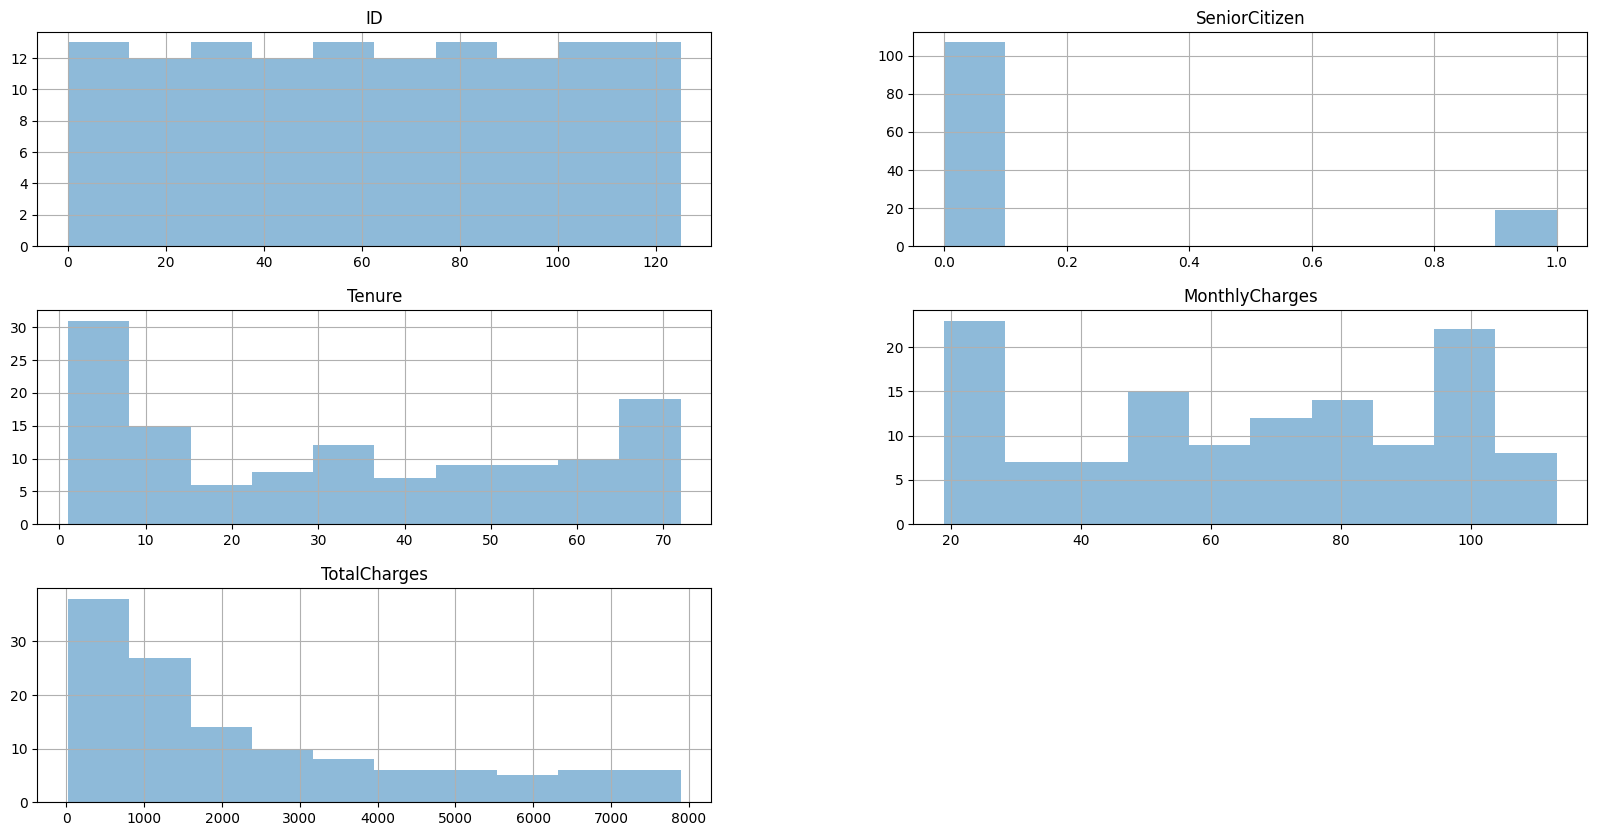

In [4]:
df.hist(alpha=0.5, figsize=(20, 10))

<AxesSubplot: >

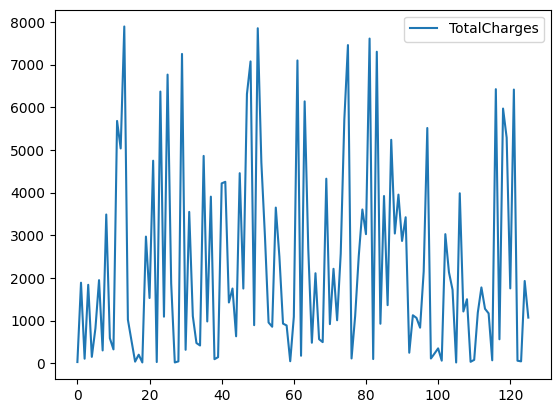

In [5]:
df.plot.line(y='TotalCharges')

<AxesSubplot: xlabel='Tenure', ylabel='MonthlyCharges'>

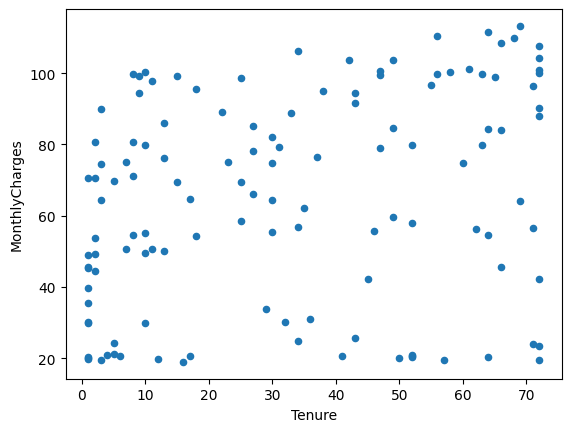

In [6]:
df.plot.scatter(y='MonthlyCharges', x='Tenure')

<AxesSubplot: >

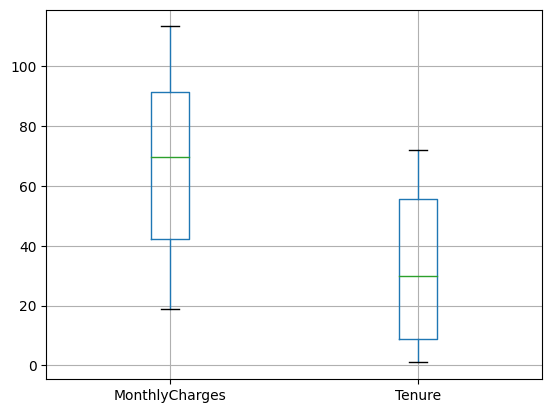

In [7]:
df.boxplot(column=['MonthlyCharges','Tenure'])

<AxesSubplot: ylabel='TotalCharges'>

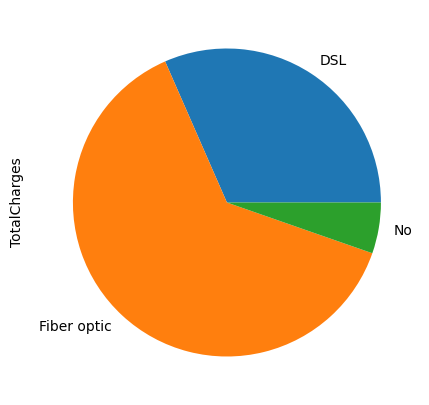

In [8]:
df2 = df.copy()
df2 = df2.groupby('InternetService')['TotalCharges'].sum()
df2.plot.pie(y='TotalCharges', figsize=(5, 5))

<AxesSubplot: xlabel='Gender'>

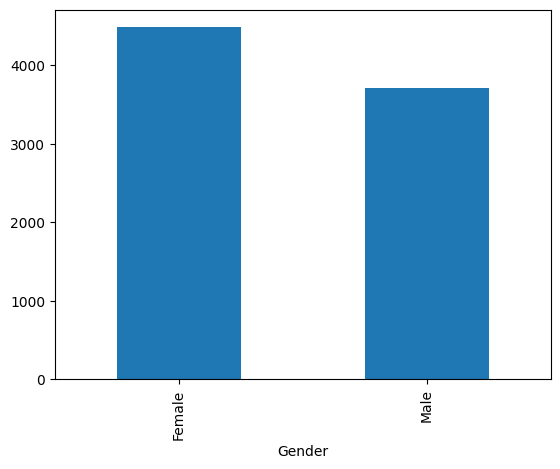

In [9]:
df3 = df.groupby('Gender')['MonthlyCharges'].sum()
df3.plot.bar(x='Gender', y='MonthlyCharges')

## Data Manupilation

In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [12]:
authors.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Married: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [13]:
indexer = StringIndexer(inputCols=['Gender', 'Married', 'PhoneService', 'MultipleLines', 'InternetService', "TechSupport", "StreamingTV", "StreamingMovies", 'Churn'], outputCols=['Gender_cat', 'Married_cat', 'PhoneService_cat', 'MultipleLines_cat', 'InternetService_cat', "TechSupport_cat", "StreamingTV_cat", "StreamingMovies_cat", 'Churn_cat'])
indexed = indexer.fit(authors).transform(authors)

In [21]:
assembler = VectorAssembler(inputCols=['Gender_cat', 'Married_cat', 'PhoneService_cat', 'MultipleLines_cat', 'InternetService_cat', "TechSupport_cat", "StreamingTV_cat", "StreamingMovies_cat", 'Tenure'], outputCol='features')

In [22]:
output = assembler.transform(indexed)
output.show()

+---+------+-------------+-------+------+------------+-------------+---------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+----------+-----------+----------------+-----------------+-------------------+---------------+---------------+-------------------+---------+--------------------+
| ID|Gender|SeniorCitizen|Married|Tenure|PhoneService|MultipleLines|InternetService|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|Gender_cat|Married_cat|PhoneService_cat|MultipleLines_cat|InternetService_cat|TechSupport_cat|StreamingTV_cat|StreamingMovies_cat|Churn_cat|            features|
+---+------+-------------+-------+------+------------+-------------+---------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+----------+-----------+----------------+---

# Logistic Regression

In [23]:
model_df = output.select('features','Churn_cat')

In [24]:
train, test = model_df.randomSplit([.7,.3])

In [29]:
regression = LogisticRegression(labelCol='Churn_cat').fit(train)
predictions = regression.evaluate(test).predictions

In [30]:
predictions.select('Churn_cat','prediction').show()

+---------+----------+
|Churn_cat|prediction|
+---------+----------+
|      0.0|       0.0|
|      0.0|       0.0|
|      1.0|       1.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      1.0|       0.0|
|      0.0|       0.0|
|      1.0|       1.0|
|      1.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
+---------+----------+
only showing top 20 rows



In [32]:
from sklearn.metrics import classification_report

prediction = predictions.toPandas()
print(classification_report(prediction['Churn_cat'], prediction['prediction']))

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84        26
         1.0       0.38      0.50      0.43         6

    accuracy                           0.75        32
   macro avg       0.62      0.65      0.63        32
weighted avg       0.78      0.75      0.76        32



# Decision Tree

In [35]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="Churn_cat")
dtc = dtc.fit(train)

In [36]:
prediction_dt = dtc.transform(test)

In [37]:
prediction_dt.show()

+--------------------+---------+-------------+--------------------+----------+
|            features|Churn_cat|rawPrediction|         probability|prediction|
+--------------------+---------+-------------+--------------------+----------+
|(9,[0,1,2,8],[1.0...|      0.0|   [27.0,0.0]|           [1.0,0.0]|       0.0|
|(9,[0,1,5,8],[1.0...|      0.0|   [27.0,0.0]|           [1.0,0.0]|       0.0|
|(9,[0,3,4,8],[1.0...|      1.0|    [4.0,7.0]|[0.36363636363636...|       1.0|
|(9,[0,3,4,8],[1.0...|      0.0|    [8.0,4.0]|[0.66666666666666...|       0.0|
|(9,[0,4,8],[1.0,2...|      0.0|    [4.0,7.0]|[0.36363636363636...|       1.0|
|(9,[0,4,8],[1.0,2...|      0.0|    [4.0,7.0]|[0.36363636363636...|       1.0|
|(9,[0,4,8],[1.0,2...|      0.0|    [3.0,1.0]|         [0.75,0.25]|       0.0|
|(9,[0,4,8],[1.0,2...|      0.0|   [27.0,0.0]|           [1.0,0.0]|       0.0|
|(9,[0,5,8],[1.0,1...|      0.0|    [4.0,7.0]|[0.36363636363636...|       1.0|
| (9,[0,8],[1.0,2.0])|      1.0|    [4.0,7.0]|[0.363

In [38]:
predictions_dt = prediction_dt.toPandas()
print(classification_report(predictions_dt['Churn_cat'], predictions_dt['prediction']))

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82        26
         1.0       0.33      0.50      0.40         6

    accuracy                           0.72        32
   macro avg       0.60      0.63      0.61        32
weighted avg       0.77      0.72      0.74        32

